In [1]:
import pandas as pd
import numpy as numpy
import requests
import json
import numpy as np
from config import api_key
from pprint import pprint
import matplotlib.pyplot as plt
import csv
import datetime
#use variable for airport - may later make a "live demo" intro Method to pull different .json and call other code?
departureIataCode = "DFW"
randomIataCode = ""
#establishes URL references from API website
Departure_url = f"http://aviation-edge.com/v2/public/timetable?key={api_key}&iataCode=DFW&type=departure"
Arrival_url = f"http://aviation-edge.com/v2/public/timetable?key={api_key}&&iataCode={randomIataCode}&type=arrival"

In [2]:
# creating function to call when converting .json pulled from appropriate URL
def get_clean_df_from_url(inputURL):
    # Performing a GET request similar to the one we executed earlier
    data = requests.get(inputURL).json()
    #JB-added terminal to the list which will give us another lookup option
    names= []
    times= []
    flights=[]
    terminal= []
    gate = []
    status = []
    length = int(len(data)-1)
    #added news list to hold airportIataCodes
    departureIataCodes = []
    arrivalIataCodes = []

    for x in range(0,length):
        names.append(data[x]["airline"]["name"])
        Time = data[x]["departure"]["scheduledTime"]
        TimeSplit = Time.split("T")[1]
        times.append(TimeSplit[:5])
        flights.append(data[x]["flight"]["iataNumber"])
        gate.append(data[x]["departure"]["gate"])
        terminal.append(data[x]["departure"]["terminal"])
        status.append(data[x]["status"])
        #added news list to hold airportIataCodes
        departureIataCodes.append(data[x]["departure"]["iataCode"])
        arrivalIataCodes.append(data[x]["arrival"]["iataCode"])

    df = pd.DataFrame()
    df["name"] =names
    df["scheduled_Time"] =pd.to_datetime(times)
    df["time"] = times
    df["iata_Number"]=flights
    df["terminal"]=terminal
    df["gate"]=gate
    df["status"]=status
    #added news df columns to hold airportIataCodes
    df["departure_Iata_Code"] = departureIataCodes
    df["arrival_Iata_Code"] = arrivalIataCodes


    #Creating new clean dataframe without cancelled and unknown status flights
    #also filtering out large known shipping carriers 
    clean_df = df.loc[(df["status"] != "cancelled") &
        (df["status"] != "unknown") &
        (df["name"] != "FedEx") &
        (df["name"] != "UPS Airlines") &
        (df["name"] != "Martinaire") &
        (df["name"] != "Ameriflight") &
        (df["name"] != "Aviastar-TU") &
        (df["name"] != "Lufthansa Cargo"),:]
    return clean_df


In [3]:
#calls previously created function to establish departure dataframe for input URL
cleanDeparture_df = get_clean_df_from_url(Departure_url)
cleanDeparture_df.head()

,name,scheduled_Time,time,iata_Number,terminal,gate,status,departure_Iata_Code,arrival_Iata_Code
0,Cathay Pacific,2020-08-16 10:00:00,10:00,CX7568,C,C10,active,DFW,LAX
1,Qantas,2020-08-16 10:00:00,10:00,QF3070,C,C10,active,DFW,LAX
2,Air Tahiti Nui,2020-08-16 10:00:00,10:00,TN1185,C,C10,active,DFW,LAX
3,American Airlines,2020-08-16 10:00:00,10:00,AA2564,C,C10,active,DFW,LAX
4,American Airlines,2020-08-16 10:00:00,10:00,AA2640,A,A34,active,DFW,JAC


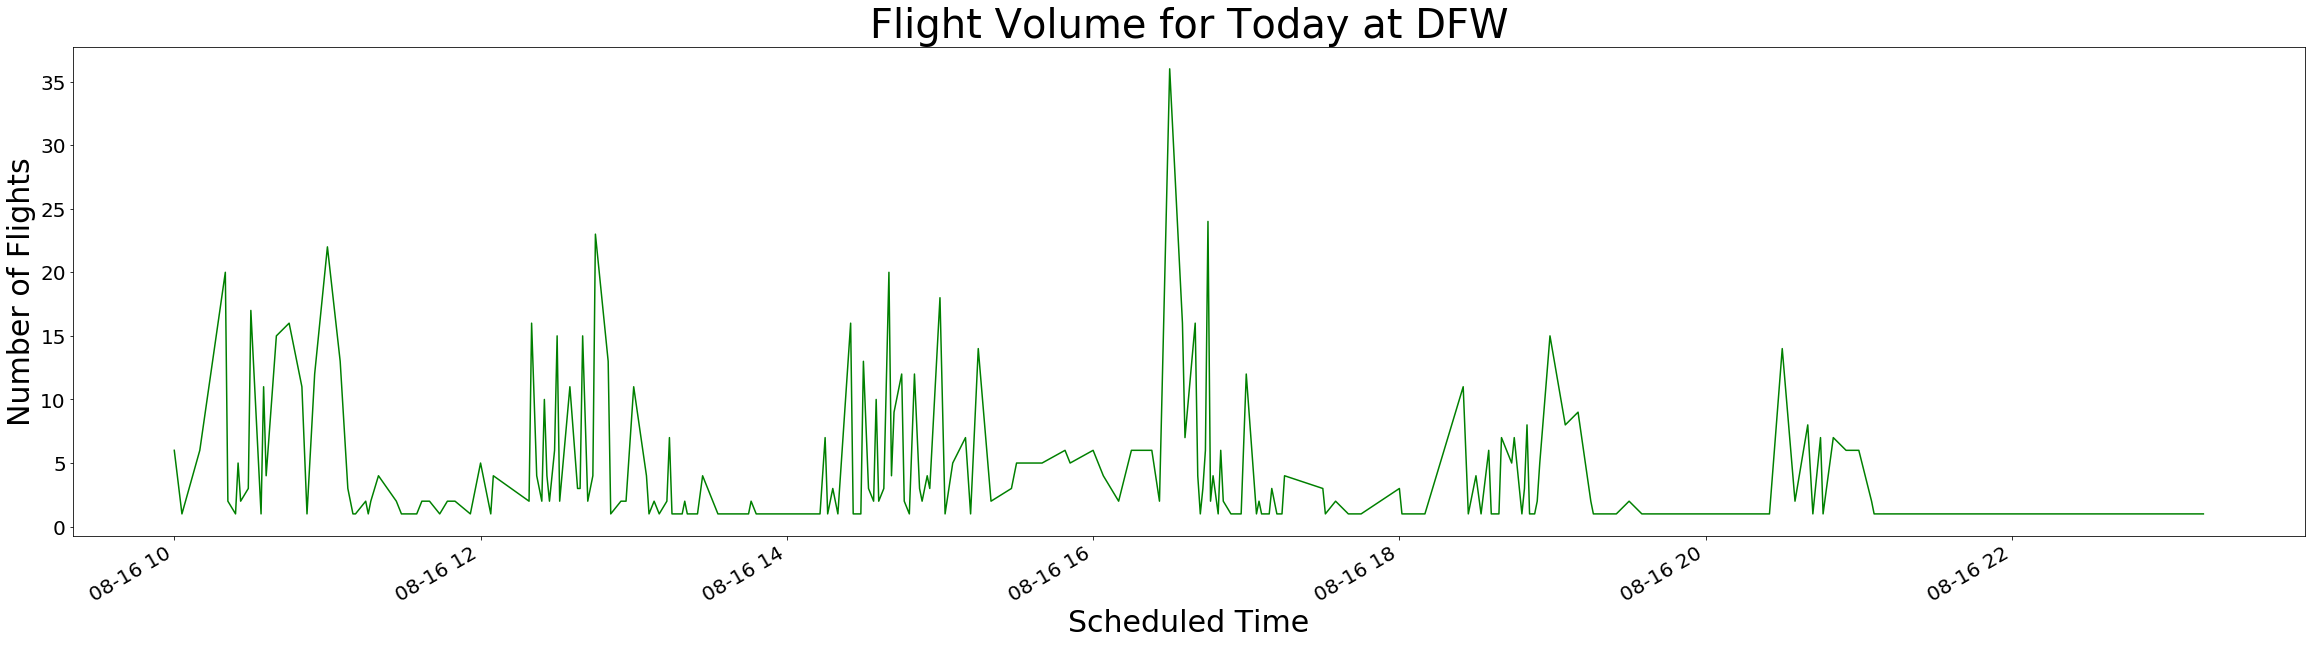

In [5]:
#general airport volume graph for today
Chart_df = cleanDeparture_df.groupby(["scheduled_Time"])["iata_Number"].count()
Chart_df.plot(kind="line", color="green", fontsize=20, figsize = (40,10))
plt.xlabel("Scheduled Time", fontsize=30)
plt.ylabel("Number of Flights", fontsize=30)
plt.title(f"Flight Volume for Today at {departureIataCode}", fontsize=40)


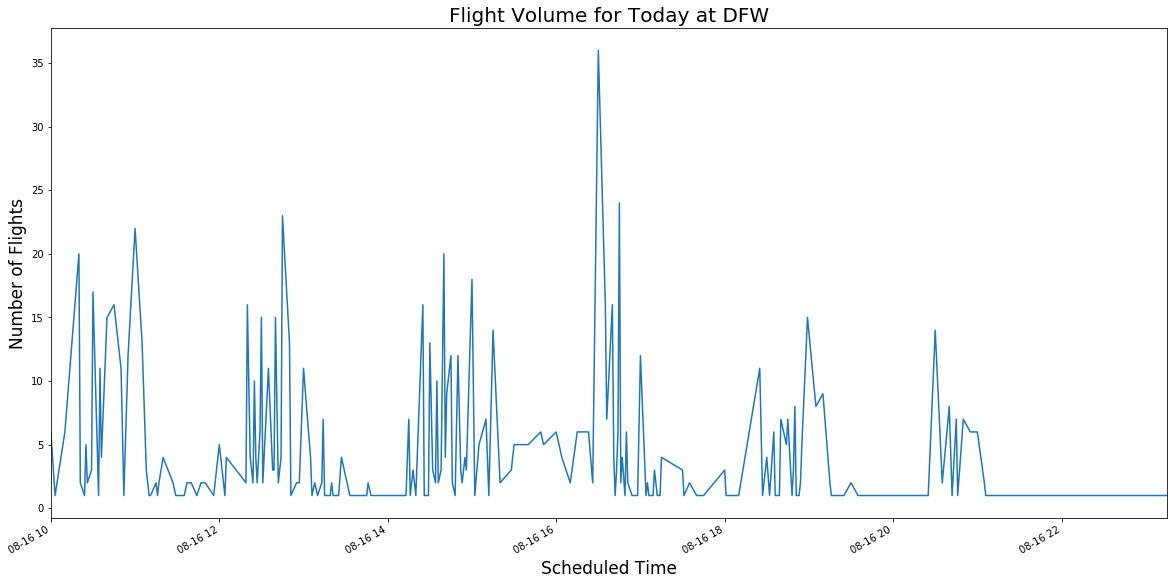

In [6]:
# Graph change with time
# This graph looks different from the original
Chart1_gb = cleanDeparture_df.groupby(["scheduled_Time"])["iata_Number"].count()
Chart1_gb.plot(kind="line", figsize = (20,10))
plt.title(f"Flight Volume for Today at {departureIataCode}", fontsize=20)
plt.xlabel("Scheduled Time", fontsize=17)
plt.ylabel("Number of Flights", fontsize=17)
plt.xlim(cleanDeparture_df["time"].min(),cleanDeparture_df["time"].max())
plt.savefig("../Resources/Total_airport_density.png")

In [8]:
#establish random sample of 1 to get data for testing
randomIataNumberSample_df = cleanDeparture_df.sample(1)
#pulls fields from sample to be used for easy comparison in following kernels
randomIataNumber = randomIataNumberSample_df.iloc[0,3]
randomDepartureScheduledTime = randomIataNumberSample_df.iloc[0,1]
randomDepartureTerminalNumber = randomIataNumberSample_df.iloc[0,4]
randomDepartureGateNumber = randomIataNumberSample_df.iloc[0,5]
randomIataCode = randomIataNumberSample_df.iloc[0,8]
#
Arrival_url = f"http://aviation-edge.com/v2/public/timetable?key={api_key}&&iataCode={randomIataCode}&type=arrival"
print(Arrival_url)
randomIataNumberSample_df

http://aviation-edge.com/v2/public/timetable?key=72f61d-5769d8&&iataCode=MFE&type=arrival


,name,scheduled_Time,time,iata_Number,terminal,gate,status,departure_Iata_Code,arrival_Iata_Code
763,American Airlines,2020-08-16 16:45:00,16:45,AA5987,B,B33,active,DFW,MFE


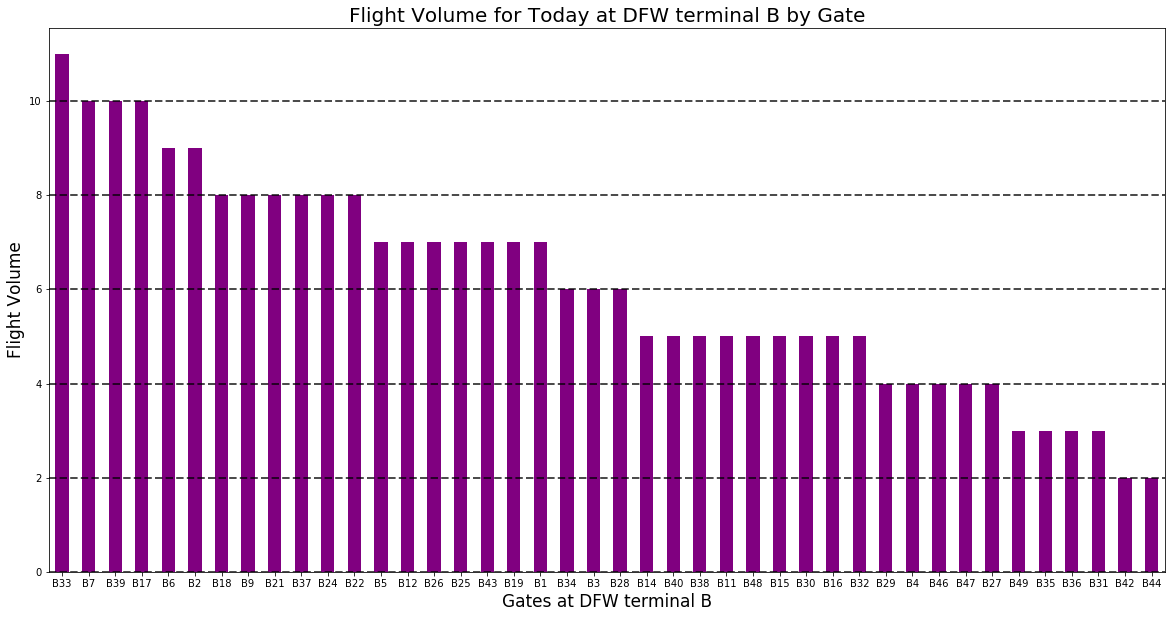

In [13]:
#code to pull and chart only information from the terminal from the random sample dataframe
gateDensity_df = cleanDeparture_df.loc[cleanDeparture_df["terminal"] == randomDepartureTerminalNumber]
gateDensityChart_df = gateDensity_df.gate.value_counts()
gateDensityChart_df.plot(kind="bar",color="purple", figsize = (20,10))
plt.title(f"Flight Volume for Today at {departureIataCode} terminal {randomDepartureTerminalNumber} by Gate", fontsize=20)
plt.xlabel(f"Gates at {departureIataCode} terminal {randomDepartureTerminalNumber}", fontsize=17)
plt.ylabel("Flight Volume", fontsize=17)
plt.xticks(rotation=0)
plt.grid(color="black", linestyle="--", linewidth=2, axis='y', alpha=0.7)
plt.savefig("../Resources/flights_at_terminal.png")

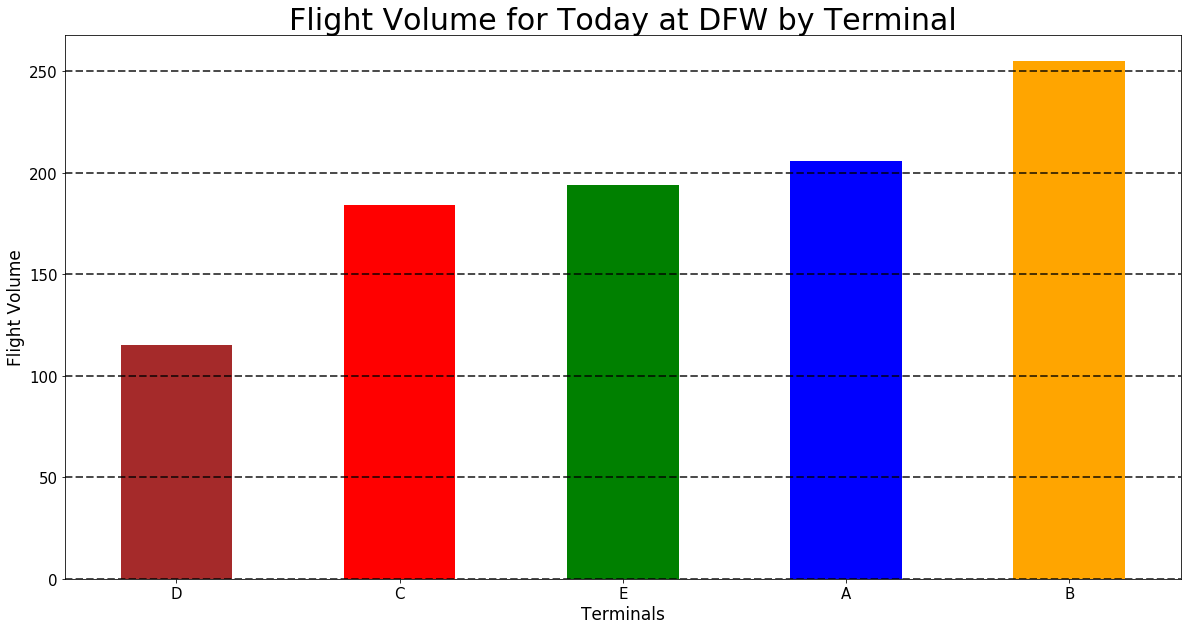

In [14]:
#code to pull and chart TERMINAL DENSITY
terminalDensityChart_df = cleanDeparture_df.terminal.value_counts().sort_values()
colors = ['brown', 'red', 'green', 'blue', 'orange']
terminalDensityChart_df.plot(kind="bar", color=colors, figsize = (20,10))
plt.title(f"Flight Volume for Today at {departureIataCode} by Terminal", fontsize=30)
plt.xlabel("Terminals", fontsize=17)
plt.ylabel("Flight Volume", fontsize=17)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)
plt.grid(color="black", linestyle="--", linewidth=2, axis='y', alpha=0.7)
plt.savefig("../Resources/flights_by_all_terminal.png")

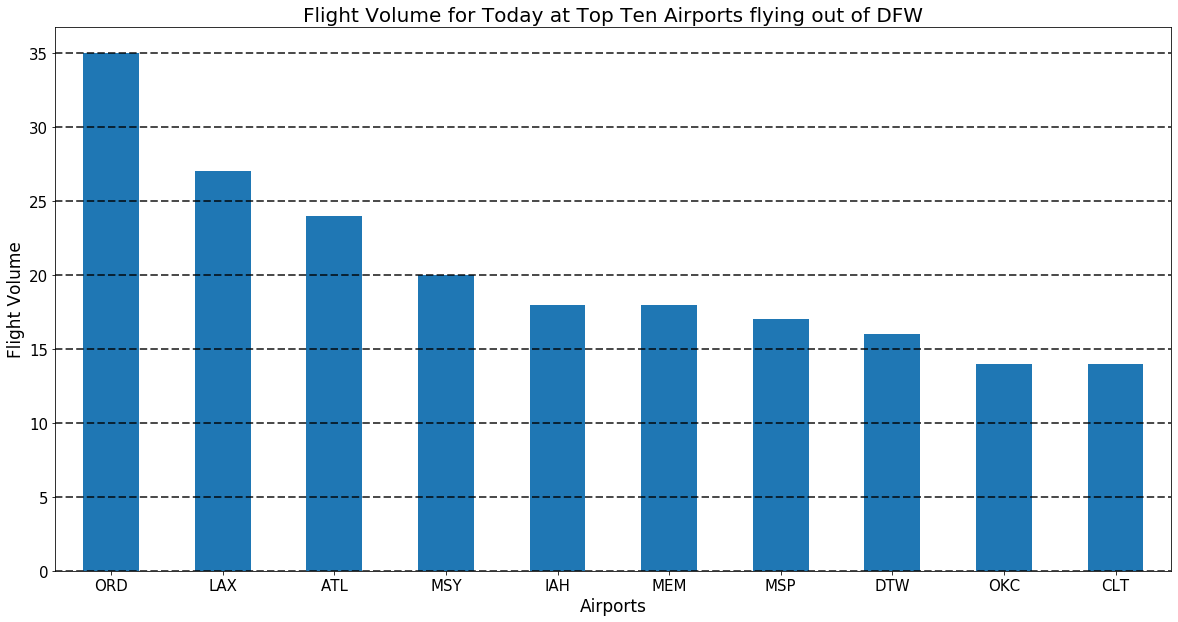

In [15]:
#code to pull and chart MOST POPULAR DESTINATIONS FROM DFW TODAY - use for top 10
topTenChart_df = cleanDeparture_df.arrival_Iata_Code.value_counts().sort_values(ascending=False).head(10)
topTenChart_df.plot(kind="bar", figsize = (20,10))
plt.title(f"Flight Volume for Today at Top Ten Airports flying out of {departureIataCode}", fontsize=20)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Airports", fontsize=17)
plt.ylabel("Flight Volume", fontsize=17)
plt.grid(color="black", linestyle="--", linewidth=2, axis='y', alpha=0.7)
plt.savefig("../Resources/Top_departure_airport.png")

In [16]:
#calls previously created function to establish departure dataframe for input URL
cleanArrival_df = get_clean_df_from_url(Arrival_url)
#establish random sample of 1 to get data for testing
randomArrivalIataNumberSample_df = cleanArrival_df.loc[cleanArrival_df["iata_Number"] == randomIataNumber]
# #pulls fields BASED ON ORIGINAL FLIGHT # from sample to be used for easy comparison in following kernels
randomArrivalScheduledTime = randomArrivalIataNumberSample_df.iloc[0,1]
randomArrivalTerminalNumber = randomArrivalIataNumberSample_df.iloc[0,4]
randomArrivalGateNumber = randomArrivalIataNumberSample_df.iloc[0,5]
print(randomIataNumber)
# #this dataframe contains all of the passenger flights pulled from the API
randomArrivalIataNumberSample_df.head()

AA5987


,name,scheduled_Time,time,iata_Number,terminal,gate,status,departure_Iata_Code,arrival_Iata_Code
23,American Airlines,2020-08-16 16:45:00,16:45,AA5987,B,B33,active,DFW,MFE


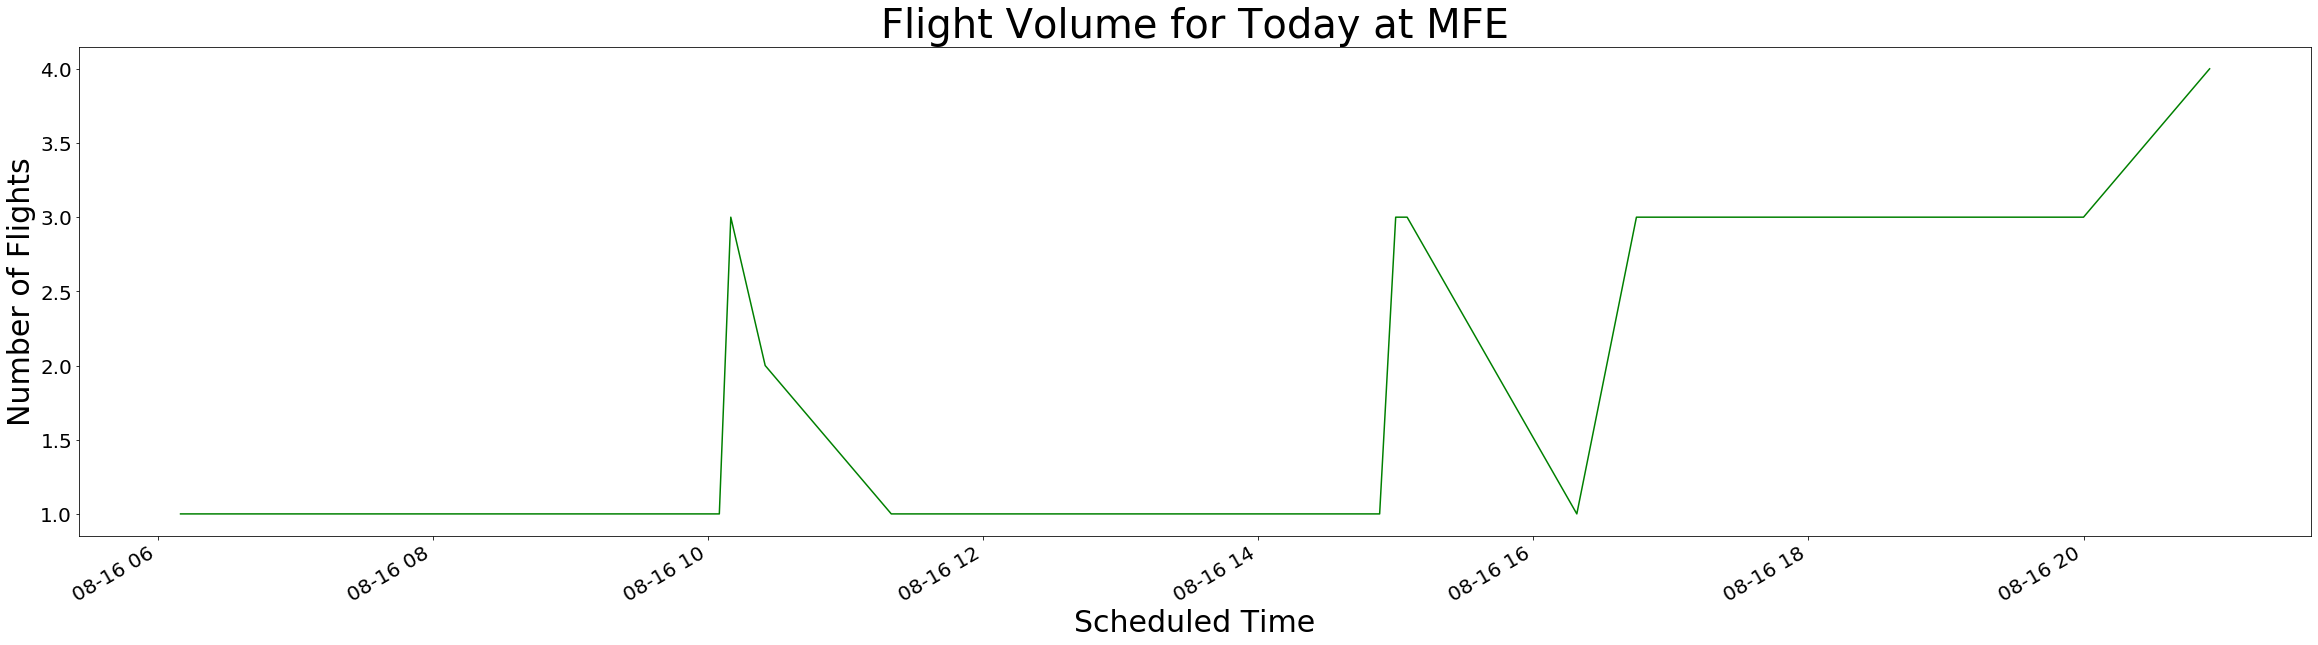

In [17]:
#code to pull and chart Arrival airport as a while
arrivalIataCode = cleanArrival_df.iloc[0,8]
arrivalChart_df = cleanArrival_df.groupby(["scheduled_Time"])["iata_Number"].count()
arrivalChart_df.plot(kind="line", color="green", fontsize=20, figsize = (40,10))
plt.xlabel("Scheduled Time", fontsize=30)
plt.ylabel("Number of Flights", fontsize=30)
plt.title(f"Flight Volume for Today at {arrivalIataCode}", fontsize=40)
plt.savefig("../Resources/arrival_airport_density.png")

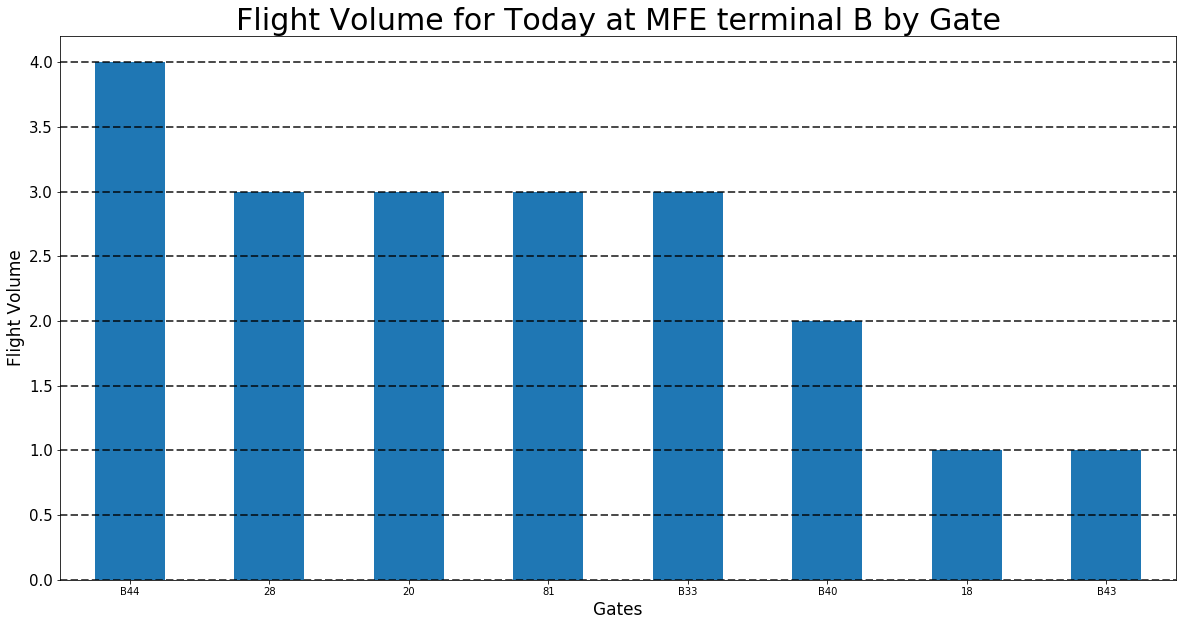

In [19]:
#code to pull and chart only information from the terminal from the random arrival sample dataframe
gateDensity_df = cleanArrival_df.loc[cleanArrival_df["terminal"] == randomArrivalTerminalNumber]
gateDensityChart_df = gateDensity_df.gate.value_counts()
gateDensityChart_df.plot(kind="bar", figsize = (20,10))
plt.title(f"Flight Volume for Today at {arrivalIataCode} terminal {randomArrivalTerminalNumber} by Gate", fontsize=30)
plt.xlabel("Gates", fontsize=17)
plt.xticks(rotation=0)
plt.ylabel("Flight Volume", fontsize=17)
plt.yticks(fontsize=15)
# plt.xticks(rotation=0)
plt.grid(color="black", linestyle="--", linewidth=2, axis='y', alpha=0.7)
plt.savefig("../Resources/arrival_term_gates.png")

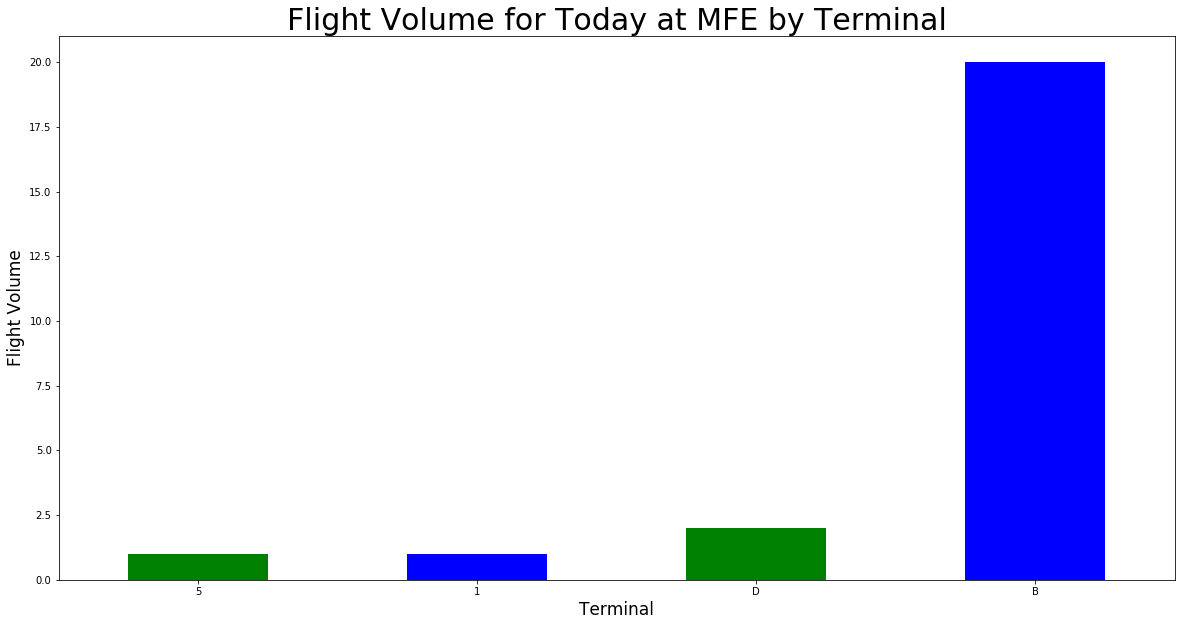

In [20]:
#code to pull and chart TERMINAL DENSITY arrival
terminalDensityChart_df = cleanArrival_df.terminal.value_counts().sort_values()
colors = ["green", "blue"]
terminalDensityChart_df.plot(kind="bar", color=colors, figsize = (20,10))
plt.xlabel("Terminal", fontsize=17)
plt.ylabel("Flight Volume", fontsize=17)
plt.title(f"Flight Volume for Today at {arrivalIataCode} by Terminal", fontsize=30)
plt.xticks(rotation=0)
plt.savefig("../Resources/arrival_terminals.png")

In [126]:
#START OF INTERACTIVE PORTION
#get input for interactive portion of presentation
userIataNumber = input("Please enter your personal Flight Number in iata format")
User_url = f"http://aviation-edge.com/v2/public/timetable?key={api_key}&flight_iata={userIataNumber}"
user_df = get_clean_df_from_url(User_url)

#pulls fields BASED ON INPUTTED FLIGHT # from to be used for easy comparison in following kernels
userDepartureScheduledTime = user_df.iloc[0,1]
userDepartureTerminalNumber = user_df.iloc[0,4]
userDeparturelGateNumber = user_df.iloc[0,5]


userDepartureIataCode = user_df.iloc[0,7]
userArrivalIataCode =user_df.iloc[0,8]
#establishes two new URLs to pull information from
userDeparture_url = f"http://aviation-edge.com/v2/public/timetable?key={api_key}&iataCode={userDepartureIataCode}&type=departure"
userArrival_url = f"http://aviation-edge.com/v2/public/timetable?key={api_key}&&iataCode={userArrivalIataCode}&type=arrival"
#establishes two new DataFrames for the departure and arrival airports for the user's inputted flight
userDeparture_df = get_clean_df_from_url(userDeparture_url)
userArrival_df = get_clean_df_from_url(userArrival_url)

userArrivalSample_df = userArrival_df.loc[userArrival_df["iata_Number"] == userIataNumber]
userArrivalScheduledTime = userArrivalSample_df.iloc[0,1]
userArrivalTerminalNumber = userArrivalSample_df.iloc[0,4]
userArrivalGateNumber = userArrivalSample_df.iloc[0,5]

#preview of user input
user_df.head()

,name,scheduled_Time,time,iata_Number,terminal,gate,status,departure_Iata_Code,arrival_Iata_Code
0,United Airlines,2020-08-16 18:15:00,18:15,UA1835,1,C17,scheduled,ORD,BUF


Text(0.5, 1.0, 'Flight Volume for Today at ORD')

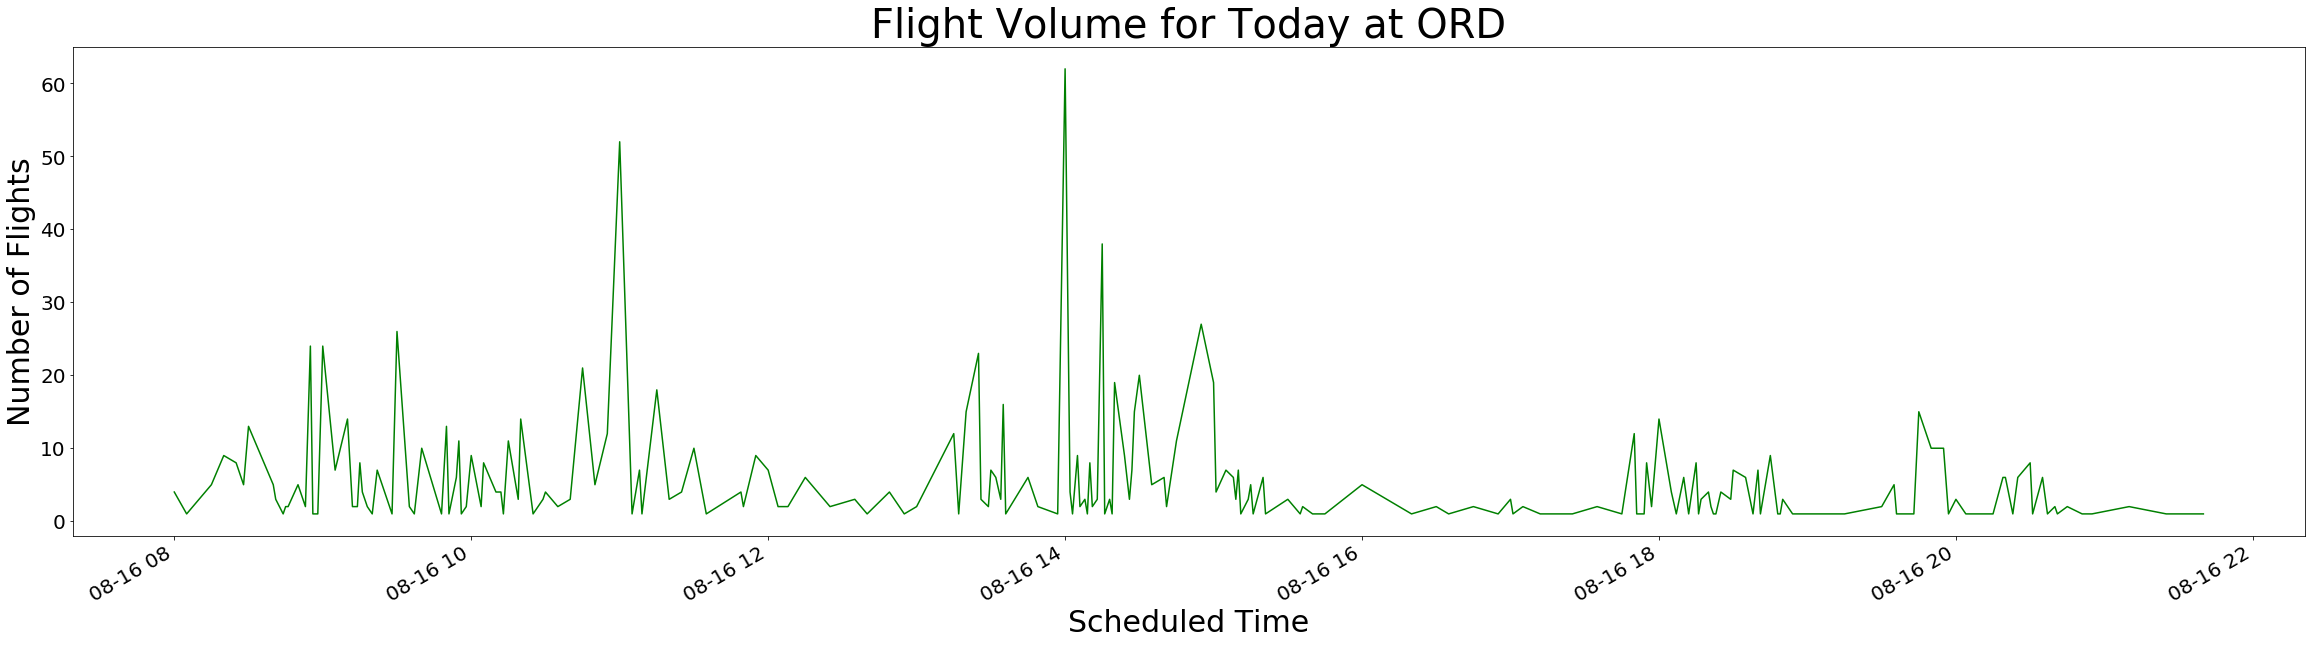

In [127]:
userChart_df = userDeparture_df.groupby(["scheduled_Time"])["iata_Number"].count()
userChart_df.plot(kind="line", color="green", fontsize=20, figsize = (40,10))
plt.xlabel("Scheduled Time", fontsize=30)
plt.ylabel("Number of Flights", fontsize=30)
plt.title(f"Flight Volume for Today at {userDepartureIataCode}", fontsize=40)

(737653.3333333334, 737653.9027777778)

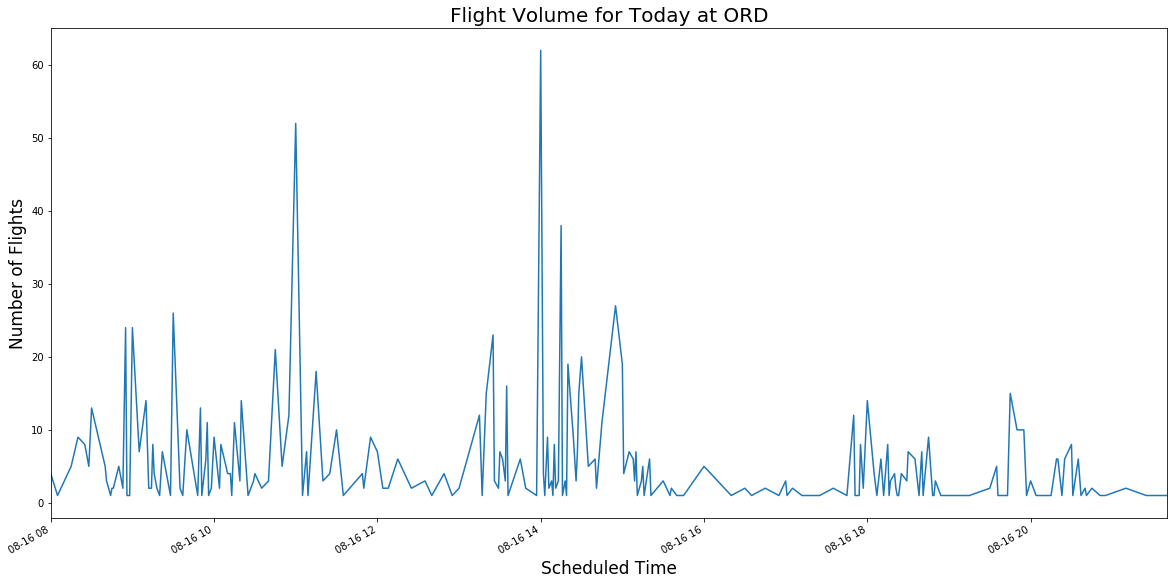

In [128]:
# Graph change with time
# This graph looks different from the original
userChart1_gb = userDeparture_df.groupby(["scheduled_Time"])["iata_Number"].count()
userChart1_gb.plot(kind="line", figsize = (20,10))
plt.title(f"Flight Volume for Today at {userDepartureIataCode}", fontsize=20)
plt.xlabel("Scheduled Time", fontsize=17)
plt.ylabel("Number of Flights", fontsize=17)
plt.xlim(userDeparture_df["time"].min(),userDeparture_df["time"].max())

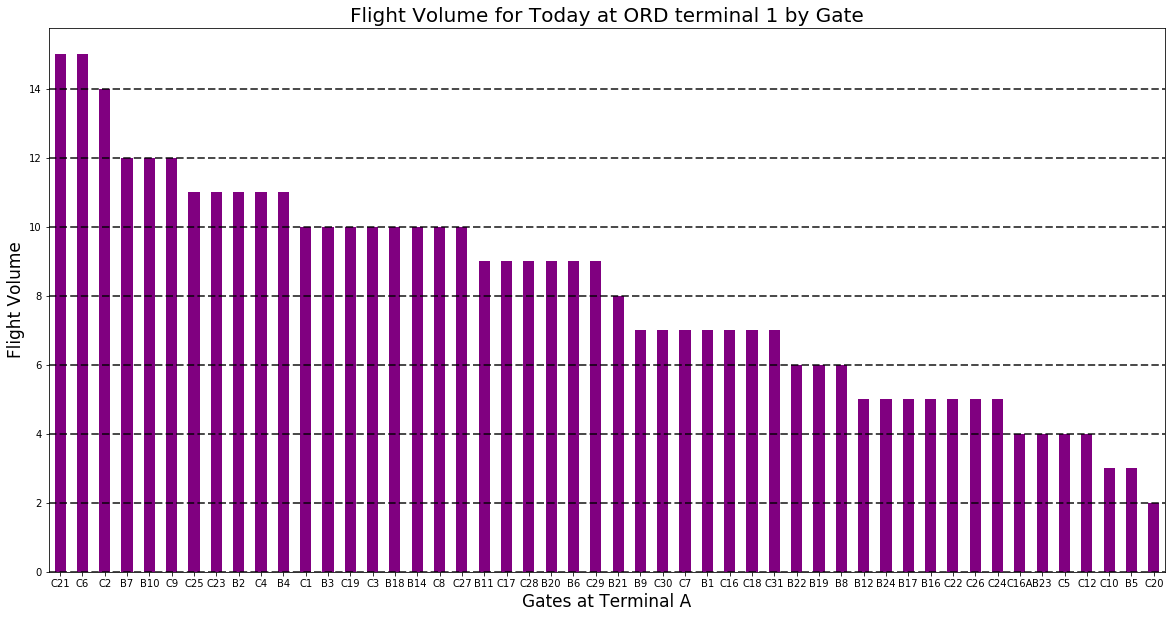

In [129]:
#code to pull and chart only information from the terminal from the random sample dataframe
userGateDensity_df = userDeparture_df.loc[userDeparture_df["terminal"] == userDepartureTerminalNumber]
userGateDensityChart_df = userGateDensity_df.gate.value_counts()
userGateDensityChart_df.plot(kind="bar",color="purple", figsize = (20,10))
plt.title(f"Flight Volume for Today at {userDepartureIataCode} terminal {userDepartureTerminalNumber} by Gate", fontsize=20)
plt.xlabel("Gates at Terminal A", fontsize=17)
plt.ylabel("Flight Volume", fontsize=17)
plt.xticks(rotation=0)
plt.grid(color="black", linestyle="--", linewidth=2, axis='y', alpha=0.7)

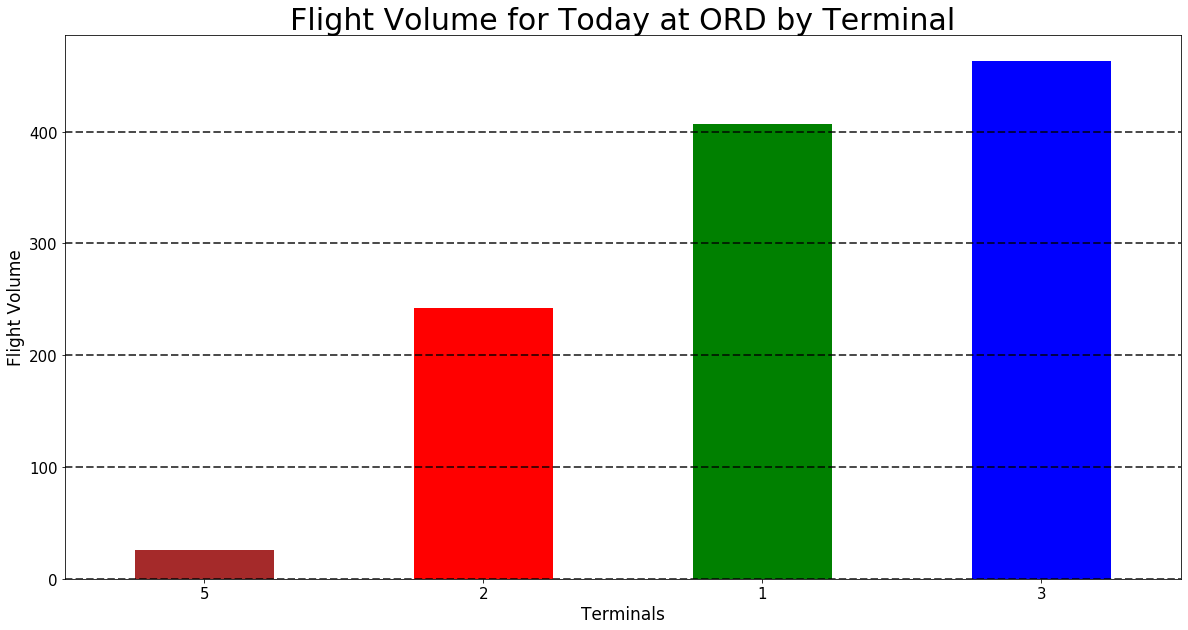

In [130]:
#code to pull and chart TERMINAL DENSITY
userTerminalDensityChart_df = userDeparture_df.terminal.value_counts().sort_values()
colors = ['brown', 'red', 'green', 'blue', 'orange']
userTerminalDensityChart_df.plot(kind="bar", color=colors, figsize = (20,10))
plt.title(f"Flight Volume for Today at {userDepartureIataCode} by Terminal", fontsize=30)
plt.xlabel("Terminals", fontsize=17)
plt.ylabel("Flight Volume", fontsize=17)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)
plt.grid(color="black", linestyle="--", linewidth=2, axis='y', alpha=0.7)

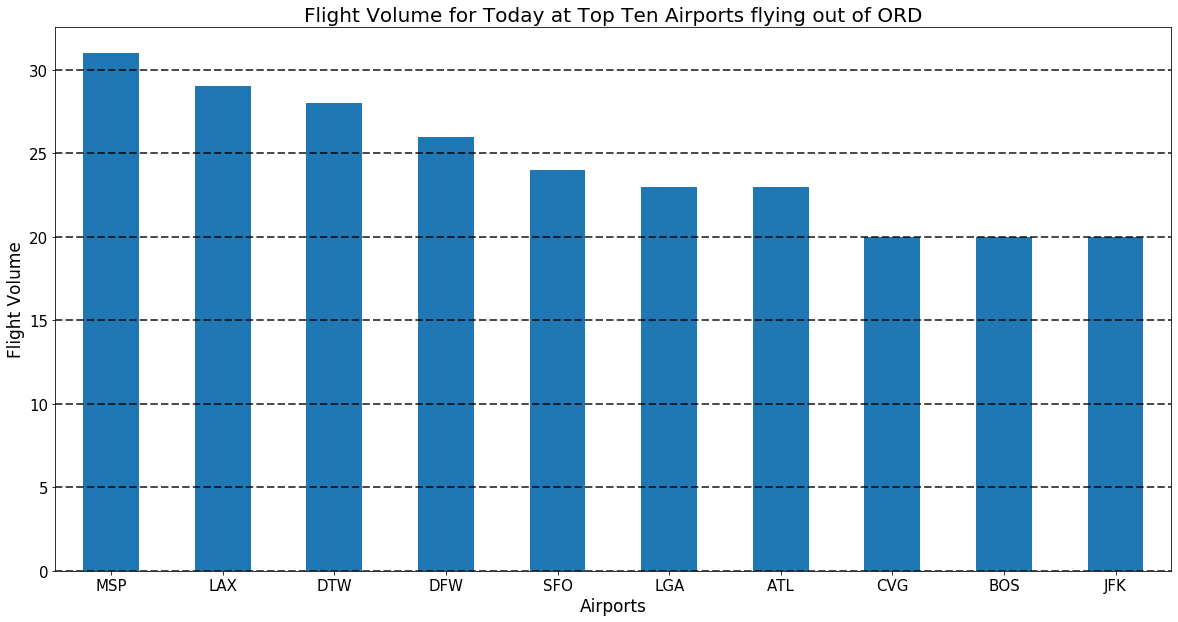

In [131]:
#code to pull and chart MOST POPULAR DESTINATIONS FROM DFW TODAY - use for top 10
topTenChart_df = userDeparture_df.arrival_Iata_Code.value_counts().sort_values(ascending=False).head(10)
topTenChart_df.plot(kind="bar", figsize = (20,10))
plt.title(f"Flight Volume for Today at Top Ten Airports flying out of {userDepartureIataCode}", fontsize=20)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Airports", fontsize=17)
plt.ylabel("Flight Volume", fontsize=17)
plt.grid(color="black", linestyle="--", linewidth=2, axis='y', alpha=0.7)

Text(0.5, 1.0, 'Flight Volume for Today at BUF')

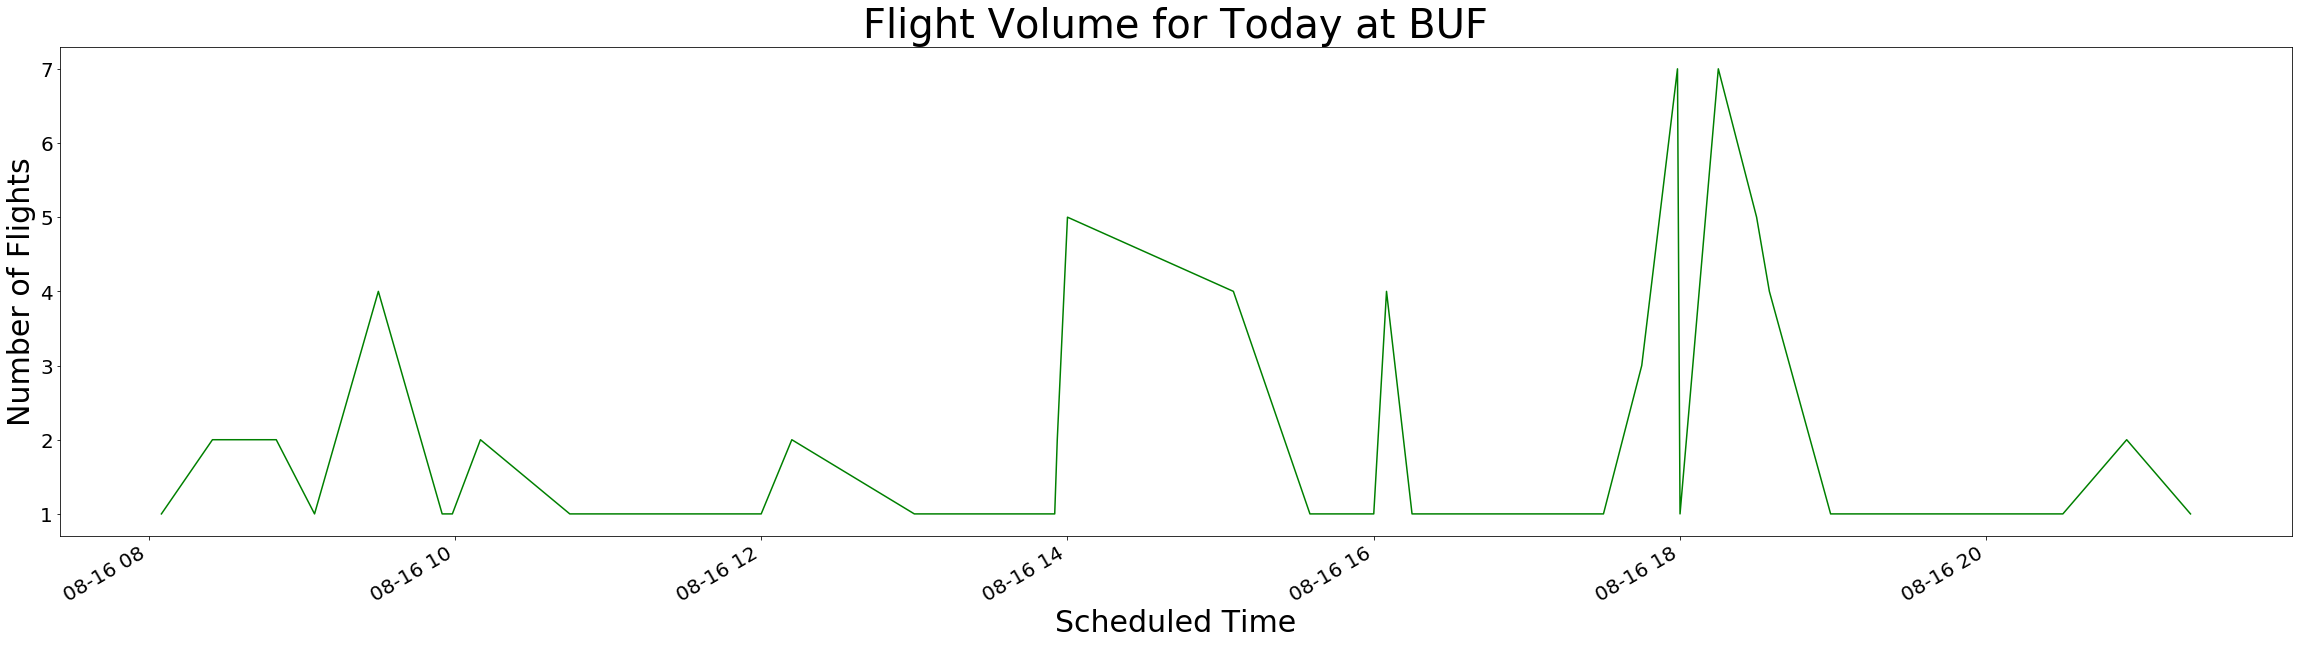

In [132]:
#code to pull and chart Arrival airport as a while
userArrivalIataCode = userArrival_df.iloc[0,8]
userArrivalChart_df = userArrival_df.groupby(["scheduled_Time"])["iata_Number"].count()
userArrivalChart_df.plot(kind="line", color="green", fontsize=20, figsize = (40,10))
plt.xlabel("Scheduled Time", fontsize=30)
plt.ylabel("Number of Flights", fontsize=30)
plt.title(f"Flight Volume for Today at {userArrivalIataCode}", fontsize=40)

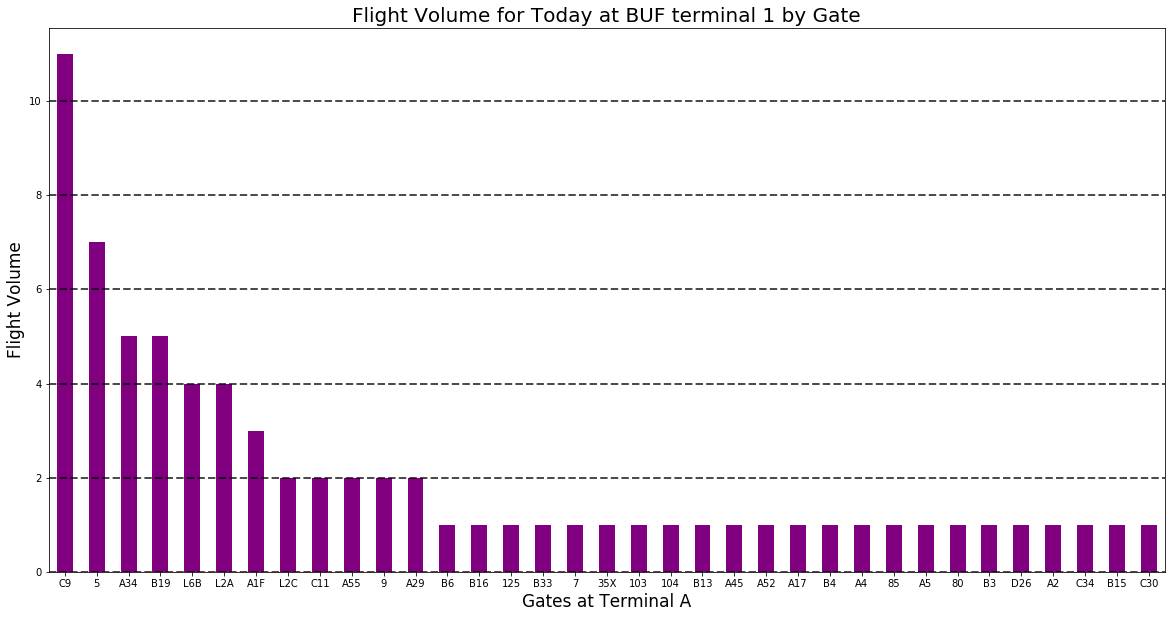

In [133]:
#code to pull and chart only information from the terminal from the random sample dataframe
userGateDensity_df = userArrival_df.loc[userArrival_df["terminal"] == userArrivalTerminalNumber]
userGateDensityChart_df = userArrival_df.gate.value_counts()
userGateDensityChart_df.plot(kind="bar",color="purple", figsize = (20,10))
plt.title(f"Flight Volume for Today at {userArrivalIataCode} terminal {userArrivalTerminalNumber} by Gate", fontsize=20)
plt.xlabel("Gates at Terminal A", fontsize=17)
plt.ylabel("Flight Volume", fontsize=17)
plt.xticks(rotation=0)
plt.grid(color="black", linestyle="--", linewidth=2, axis='y', alpha=0.7)

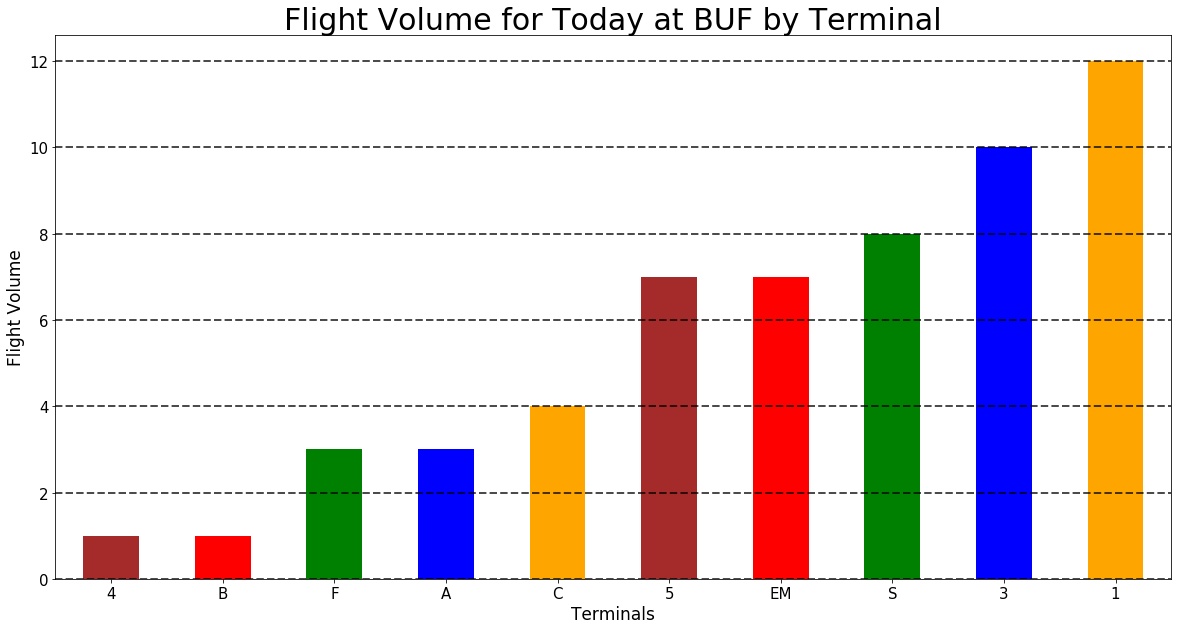

In [134]:
#code to pull and chart TERMINAL DENSITY
userTerminalDensityChart_df = userArrival_df.terminal.value_counts().sort_values()
colors = ['brown', 'red', 'green', 'blue', 'orange']
userTerminalDensityChart_df.plot(kind="bar", color=colors, figsize = (20,10))
plt.title(f"Flight Volume for Today at {userArrivalIataCode} by Terminal", fontsize=30)
plt.xlabel("Terminals", fontsize=17)
plt.ylabel("Flight Volume", fontsize=17)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)
plt.grid(color="black", linestyle="--", linewidth=2, axis='y', alpha=0.7)